In [1]:
import math
import os


os.environ["KERAS_BACKEND"] = "torch"


import numpy as np
import pandas as pd
from keras.layers import LSTM, Dense, Dropout, Normalization, Input
from keras.models import Sequential
from matplotlib import pyplot as plt


def is_prime(n):
    if n == 1:
        return False
    if n == 2:
        return True
    for ith in range(3, math.ceil(math.sqrt(n)), 2):
        if n % ith == 0:
            return False
            
    return True

True

In [2]:
df = pd.read_csv("../../.data/lowhigh_2023_2025.csv")
del df["Unnamed: 0"]
df = df[df["low"] != "NOT AVAILABLE"]
df = df.dropna()
df

,date,market,commodity,low,high
0,2024-01-02,Taguig People's Market,sugar (washed),75.0,80.0
1,2024-01-02,Dagonoy Market,pechay baguio,80.0,90.0
2,2024-01-02,Marikina Public Market,well-milled rice (local),48.00,48.00
3,2024-01-02,Guadalupe Public Market/Makati,tilapia,140.0,150.0
4,2024-01-02,Guadalupe Public Market/Makati,corn (yellow),60.00,80.00
...,...,...,...,...,...
151828,2025-02-25,Kamuning Public Market,cabbage,70.0,90.0
151829,2025-02-25,Kamuning Public Market,tomato,40.0,60.0
151830,2025-02-25,Kamuning Public Market,eggplant,90.0,100.0
151831,2025-02-25,Muñoz Market/Quezon City,cabbage,50.0,120.0


In [3]:
data_by_commodities = {}

for commodity in set(df["commodity"]):
    # print("[INFO] processing:", commodity)
    data_by_commodities[commodity] = df.loc[df["commodity"] == commodity]

data_by_commodities

{'pechay baguio':               date                           market      commodity   low  high
 1       2024-01-02                   Dagonoy Market  pechay baguio  80.0  90.0
 37      2024-01-02           Kamuning Public Market  pechay baguio  60.0  80.0
 40      2024-01-02   Guadalupe Public Market/Makati  pechay baguio  60.0  80.0
 41      2024-01-02  Commonwealth Market/Quezon City  pechay baguio  90.0  90.0
 54      2024-01-02     Agora Public Market/San Juan  pechay baguio  40.0  70.0
 ...            ...                              ...            ...   ...   ...
 146514  2025-02-07          Mega Q-mart/Quezon City  pechay baguio  45.0  80.0
 146518  2025-02-07   Maypajo Public Market/Caloocan  pechay baguio  60.0  80.0
 146526  2025-02-07           Marikina Public Market  pechay baguio  70.0  90.0
 146530  2025-02-07        Mandaluyong Public Market  pechay baguio  80.0  80.0
 146534  2025-02-07           Malabon Central Market  pechay baguio  80.0  90.0
 
 [8306 rows x 5 colum

In [4]:
data_by_market = {}
for market in set(df["market"]):
    data_by_market[market] = df[df["market"] == market]

data_by_market

{'Murphy Public Market':               date                market          commodity    low   high
 183     2024-01-02  Murphy Public Market  red onion (local)  180.0  200.0
 184     2024-01-02  Murphy Public Market      pechay baguio   70.0   80.0
 185     2024-01-02  Murphy Public Market            cabbage  70.00  80.00
 186     2024-01-02  Murphy Public Market             tomato   80.0   90.0
 187     2024-01-02  Murphy Public Market           ampalaya  120.0  140.0
 ...            ...                   ...                ...    ...    ...
 151777  2025-02-25  Murphy Public Market  red onion (local)  150.0  200.0
 151779  2025-02-25  Murphy Public Market            cabbage   60.0   90.0
 151780  2025-02-25  Murphy Public Market           eggplant   70.0  100.0
 151781  2025-02-25  Murphy Public Market           ampalaya  110.0  140.0
 151789  2025-02-25  Murphy Public Market             tomato   40.0   60.0
 
 [3276 rows x 5 columns],
 'Pasay City Market':               date        

In [5]:
# df_commodity = data_by_commodities["cabbage (scorpio)"]
# df_commodity = data_by_commodities["eggplant"]  # NOTE: data too low, do not include
# df_commodity = data_by_commodities[""]
# df_commodity_market = df_commodity[df_commodity["market"] == "Pateros Market"]

df_market = data_by_market["Pateros Market"]
df_commodity_market = df_market[df_market["commodity"] == "tilapia"]
x = pd.to_datetime(df_commodity_market["date"])
low = pd.to_numeric(df_commodity_market["low"])
high = pd.to_numeric(df_commodity_market["high"])
df_commodity_market

,date,market,commodity,low,high
266,2024-01-02,Pateros Market,tilapia,160.0,160.0
401,2024-01-03,Pateros Market,tilapia,160.0,160.0
622,2024-01-04,Pateros Market,tilapia,160.0,160.0
923,2024-01-05,Pateros Market,tilapia,160.0,160.0
1346,2024-01-09,Pateros Market,tilapia,160.0,160.0
...,...,...,...,...,...
149832,2025-02-19,Pateros Market,tilapia,160.0,160.0
150129,2025-02-20,Pateros Market,tilapia,160.0,160.0
150432,2025-02-21,Pateros Market,tilapia,160.00,160.00
151207,2025-02-24,Pateros Market,tilapia,160.0,160.0


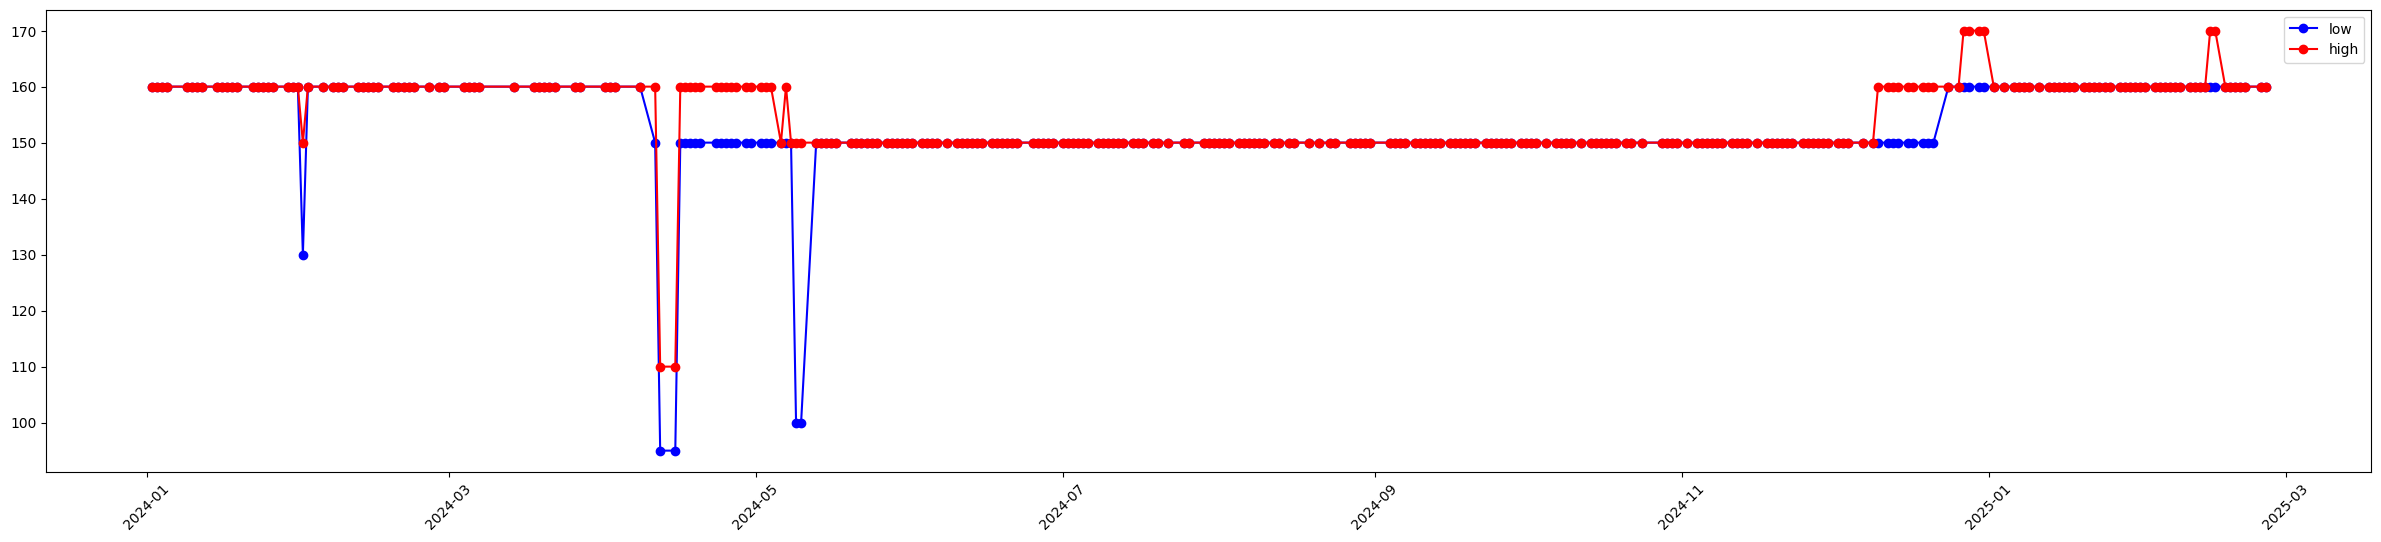

In [6]:
plt.figure(figsize=(30, 6))
plt.xticks(rotation=45)
plt.plot(x, low, "o-b", x, high, "o-r")
plt.legend(["low", "high"])

In [7]:
df_train = df_commodity_market[["high", "low"]]
if is_prime(df_train.shape[0]):
    df_train = df_train.iloc[1:]
df_train = df_train.iloc[::-1]
df_train.shape

(295, 2)

In [8]:
train_x = []
train_y = []
train_n_future = 1
train_n_past = 5

for ith in range(0, df_train.shape[0], train_n_past + train_n_future):
    tail = ith + train_n_past
    past = df_train.iloc[ith:tail].to_numpy(dtype="float32")
    if past.shape[0] == train_n_past:
        train_x.append(past)
    else:
        continue
    train_y.append(df_train.iloc[tail:tail + train_n_future, 0:df_train.shape[1] - 1].to_numpy(dtype="float32"))

train_x, train_y

([array([[160., 160.],
         [160., 160.],
         [160., 160.],
         [160., 160.],
         [160., 160.]], dtype=float32),
  array([[160., 160.],
         [170., 160.],
         [170., 160.],
         [160., 160.],
         [160., 160.]], dtype=float32),
  array([[160., 160.],
         [160., 160.],
         [160., 160.],
         [160., 160.],
         [160., 160.]], dtype=float32),
  array([[160., 160.],
         [160., 160.],
         [160., 160.],
         [160., 160.],
         [160., 160.]], dtype=float32),
  array([[160., 160.],
         [160., 160.],
         [160., 160.],
         [160., 160.],
         [160., 160.]], dtype=float32),
  array([[160., 160.],
         [160., 160.],
         [160., 160.],
         [160., 160.],
         [160., 160.]], dtype=float32),
  array([[160., 160.],
         [160., 160.],
         [160., 160.],
         [160., 160.],
         [160., 160.]], dtype=float32),
  array([[160., 160.],
         [160., 160.],
         [170., 160.],
       

In [9]:
train_x = np.array(train_x)
train_y = np.array(train_y)
train_x.shape, train_y.shape

((49, 5, 2), (49, 1, 1))

In [10]:
mean = np.mean([low, high])
var = np.var([low, high])

model = Sequential()
model.add(Input(shape=(train_x.shape[1], train_x.shape[2])))
model.add(Normalization(mean=mean, variance=var))
model.add(LSTM(128, activation="relu", return_sequences=True))
model.add(LSTM(64, activation="relu", return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(train_y.shape[1]))
model.add(Normalization(mean=mean, variance=var, invert=True))

model.compile(optimizer="nadam", loss="mse")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 5, 2)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 5, 128)         │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_1 (Normalization) │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,545 (455.25 KB)

 Trainable params: 116,545 (455.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 27.0746 - val_loss: 38.3027
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 28.0366 - val_loss: 34.6162
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 26.7749 - val_loss: 30.5765
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 24.1588 - val_loss: 25.4055
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 21.2431 - val_loss: 19.5703
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 14.9179 - val_loss: 12.0679
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 9.8339 - val_loss: 4.2180
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 8.1183 - val_loss: 0.2362
Epoch 9/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 6.0494 - val_loss: 0.2423
Epoch 10/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 7.0008 - val_loss: 0.2186
Epoch 11/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 5.8478 - val_loss: 0.1380
Epoch 12/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 3.8

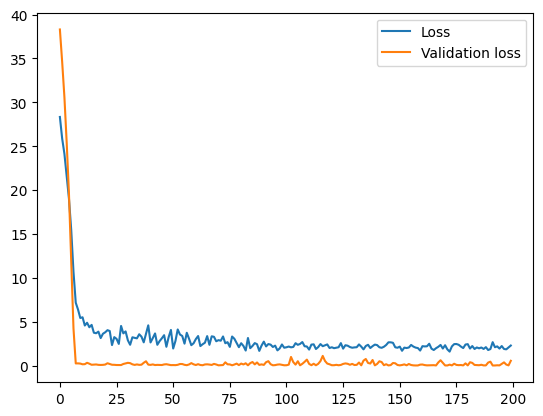

In [11]:
hist = model.fit(train_x, train_y, epochs=200, batch_size=16, validation_split=0.1, verbose=1)
plt.plot(hist.history["loss"], label="Loss")
plt.plot(hist.history["val_loss"], label="Validation loss")
plt.legend()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


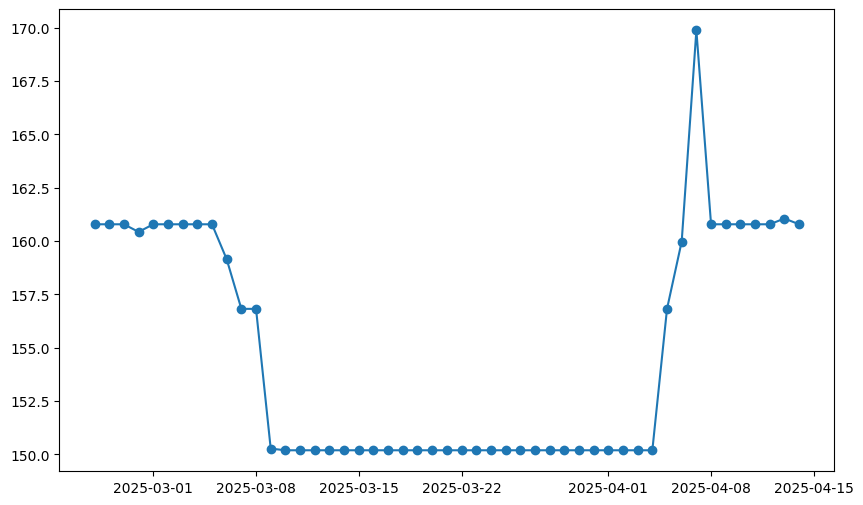

In [12]:
days_to_predict = train_x.shape[0]
train_x_rev = train_x[::-1] 
date = pd.to_datetime(df.iloc[df.shape[0] - 1]["date"])
dates = [date + pd.Timedelta(days=ith) for ith in range(days_to_predict)]
prices = model.predict(train_x_rev[-days_to_predict:])
plt.figure(figsize=(10, 6))
plt.plot(dates, prices, "o-")